<a href="https://www.kaggle.com/code/ishwor2048/diabetes-prediction-lgb-with-robust-data-visuals?scriptVersionId=286477092" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1><b>KAGGLE PLAYGROUND S5E12 – Refined Version with more EDA and end to end solution

<h3><b>Import necessary libraries and modules

In [1]:
# --------------------------
# Basic Libraries
# --------------------------
import numpy as np
import pandas as pd
import random
import os

# ------------------------
# Data visualization libraries
# ------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------
# Scikit-learn for machine learning models, CV, evaluation and preprocessing
# --------------------------------------
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

import lightgbm as lgb

<h3><b>Reproducibility

In [2]:
# Setting the  seed value
SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)

set_seed()

<h3><b>Load Dataset

We will load the training and test dataset to train and evaluate model's performance on seen and unseen data

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv") # Training dataset to train the model
test = pd.read_csv("/kaggle/input/playground-series-s5e12/test.csv") # Test dataset in order to test model's performance on unseen data

In [4]:
# Check rows and columns of my dataset
print(f"There are {train.shape[0]} number of rows and {train.shape[1]} number of columns in the training dataset")

There are 700000 number of rows and 26 number of columns in the training dataset


In [5]:
# Check rows and columns of the test dataset
test.shape

(300000, 25)

In [6]:
# Making sure that all the rows and column and cell values are visible without any truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
# Looking at a first 5 rows of the training dataset
train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,85,206,49,131,124,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [8]:
# Looking at random few rows of the training and test dataset
train.sample(10)

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
637949,637949,60,2,144,4.3,7.3,5.5,23.1,0.83,100,68,65,192,59,99,97,Female,Black,Highschool,Lower-Middle,Never,Employed,0,1,0,1.0
656465,656465,50,2,48,4.7,7.2,9.1,26.6,0.92,120,79,71,166,56,83,123,Female,Hispanic,Graduate,Middle,Current,Employed,0,1,0,0.0
337739,337739,34,1,123,3.4,7.0,7.1,24.1,0.88,107,84,85,200,64,101,147,Female,White,Highschool,Lower-Middle,Never,Employed,0,0,0,1.0
230222,230222,52,2,26,6.1,7.3,5.0,22.9,0.83,119,82,61,223,48,137,115,Male,Hispanic,Highschool,Middle,Current,Employed,0,0,0,1.0
82039,82039,39,3,70,4.9,8.8,7.8,29.3,0.84,116,82,63,196,60,105,139,Female,White,Highschool,Middle,Never,Employed,0,0,0,0.0
333655,333655,68,3,80,5.0,7.7,0.7,24.2,0.83,117,82,73,203,75,98,106,Male,Hispanic,Postgraduate,Middle,Never,Employed,0,0,0,1.0
668993,668993,40,1,95,7.3,7.9,5.6,26.2,0.87,103,62,75,197,57,112,127,Female,White,Graduate,Middle,Current,Employed,0,0,0,0.0
394818,394818,67,2,42,4.6,6.7,5.1,26.4,0.84,128,85,87,189,51,94,134,Female,White,Highschool,Middle,Never,Employed,0,0,0,1.0
54454,54454,26,1,12,4.6,7.5,7.2,32.9,0.91,112,70,81,184,37,107,162,Male,Hispanic,Graduate,Middle,Current,Retired,0,0,0,1.0
211991,211991,49,1,381,6.6,7.7,9.4,26.8,0.88,110,77,80,187,57,90,110,Female,White,Postgraduate,Lower-Middle,Never,Retired,1,0,0,1.0


In [9]:
test.sample(10) # this will shuffle the dataset at row level, and will pull random 10 rows

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
295215,995215,36,2,121,7.5,4.5,8.5,27.4,0.88,109,65,73,174,49,93,182,Female,Hispanic,Graduate,Lower-Middle,Former,Employed,0,0,0
173243,873243,58,3,147,7.1,6.5,7.7,23.8,0.88,123,75,72,184,50,109,121,Female,White,Highschool,Lower-Middle,Former,Employed,0,0,0
276858,976858,37,2,90,4.9,6.8,5.3,25.5,0.84,95,82,64,200,66,100,107,Female,Black,Graduate,Lower-Middle,Never,Employed,1,0,0
292411,992411,76,2,102,5.7,7.5,4.7,24.0,0.83,127,82,65,195,48,101,92,Male,Other,Highschool,Middle,Former,Employed,0,0,0
95492,795492,62,1,118,5.5,7.0,7.1,24.5,0.87,117,75,76,208,62,108,98,Male,White,Highschool,Middle,Never,Unemployed,0,0,0
166223,866223,35,4,95,5.5,7.1,8.0,27.7,0.87,116,77,63,172,69,72,139,Male,Asian,Highschool,Lower-Middle,Former,Employed,1,1,0
282037,982037,41,3,108,5.3,6.0,8.6,23.5,0.84,94,79,70,173,58,84,81,Male,Black,Highschool,Upper-Middle,Never,Employed,0,0,0
234989,934989,28,3,69,5.1,7.1,5.6,26.2,0.87,110,72,72,180,62,82,181,Male,Hispanic,Highschool,Middle,Never,Employed,0,0,0
143900,843900,62,1,27,4.4,6.4,4.7,22.1,0.86,116,87,91,185,67,91,94,Male,Black,Highschool,Middle,Current,Retired,0,0,0
212268,912268,72,1,73,6.7,6.3,2.4,26.8,0.91,128,73,67,219,58,123,146,Male,Black,Highschool,Middle,Never,Employed,0,0,0


<h3><b>Statistical description of the dataset

In [10]:
train.describe(exclude="object") # checking statistical description of the training dataset, numerical columns

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,349999.500000,50.359734,2.072411,80.230803,5.963695,7.002200,6.012733,25.874684,0.858766,116.294193,75.440924,70.167749,186.818801,53.823214,102.905854,123.081850,0.149401,0.181990,0.030324,0.623296
std,202072.738554,11.655520,1.048189,51.195071,1.463336,0.901907,2.022707,2.860705,0.037980,11.010390,6.825775,6.938722,16.730832,8.266545,19.022416,24.739397,0.356484,0.385837,0.171478,0.484560
min,0.000000,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.680000,91.000000,51.000000,42.000000,117.000000,21.000000,51.000000,31.000000,0.000000,0.000000,0.000000,0.000000
25%,174999.750000,42.000000,1.000000,49.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,175.000000,48.000000,89.000000,106.000000,0.000000,0.000000,0.000000,0.000000
50%,349999.500000,50.000000,2.000000,71.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000,1.000000
75%,524999.250000,58.000000,3.000000,96.000000,7.000000,7.600000,7.400000,27.800000,0.880000,124.000000,80.000000,75.000000,199.000000,59.000000,116.000000,139.000000,0.000000,0.000000,0.000000,1.000000
max,699999.000000,89.000000,9.000000,747.000000,9.900000,9.900000,16.500000,38.400000,1.050000,163.000000,104.000000,101.000000,289.000000,90.000000,205.000000,290.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train.describe(include="object") # checking statistical description of object columns in the training data

,gender,ethnicity,education_level,income_level,smoking_status,employment_status
count,700000,700000,700000,700000,700000,700000
unique,3,5,4,5,3,4
top,Female,White,Highschool,Middle,Never,Employed
freq,363237,386153,344145,290557,494448,516170


In [12]:
test.describe().T # Checking statistical description of the numerical columns of the test dataset, in transpose format (rows to columns and vis-a-versa)

,count,mean,std,min,25%,50%,75%,max
id,300000.0,849999.500000,86602.684716,700000.00,774999.75,849999.50,924999.25,999999.00
age,300000.0,50.432397,11.938741,19.00,42.00,50.00,59.00,89.00
alcohol_consumption_per_week,300000.0,2.089693,1.066214,1.00,1.00,2.00,3.00,9.00
physical_activity_minutes_per_week,300000.0,92.349087,62.187399,1.00,51.00,77.00,115.00,748.00
diet_score,300000.0,5.945838,1.481068,0.10,5.00,6.00,7.00,9.90
sleep_hours_per_day,300000.0,6.997795,0.914693,3.10,6.40,7.00,7.60,9.90
screen_time_hours_per_day,300000.0,6.011278,2.060472,0.60,4.60,6.00,7.40,15.90
bmi,300000.0,25.881906,2.894289,15.10,23.90,25.90,27.80,38.30
waist_to_hip_ratio,300000.0,0.859007,0.038523,0.69,0.83,0.86,0.89,1.05
systolic_bp,300000.0,116.374117,11.252146,91.00,108.00,116.00,124.00,170.00


In [13]:
test.describe(include="object").T # Statistical description of the categorical columns of the test datasets

,count,unique,top,freq
gender,300000,3,Female,154098
ethnicity,300000,5,White,168375
education_level,300000,4,Highschool,153355
income_level,300000,5,Middle,124249
smoking_status,300000,3,Never,211666
employment_status,300000,4,Employed,217993


In [14]:
train.info() # Looking at the data information, rows, columns, data types, missing rows, etc.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [15]:
train.ethnicity.value_counts() # counting number of records for each category of ethnicity column

ethnicity
White       386153
Hispanic    129984
Black       106301
Asian        60120
Other        17442
Name: count, dtype: int64

In [16]:
train.employment_status.value_counts() # counting number of rows for each category of employment status

employment_status
Employed      516170
Retired       115735
Unemployed     49787
Student        18308
Name: count, dtype: int64

In [17]:
test.info() # checking data information for the test set, including rows, columns, data types of each columns, missing rows, etc.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  300000 non-null  int64  
 1   age                                 300000 non-null  int64  
 2   alcohol_consumption_per_week        300000 non-null  int64  
 3   physical_activity_minutes_per_week  300000 non-null  int64  
 4   diet_score                          300000 non-null  float64
 5   sleep_hours_per_day                 300000 non-null  float64
 6   screen_time_hours_per_day           300000 non-null  float64
 7   bmi                                 300000 non-null  float64
 8   waist_to_hip_ratio                  300000 non-null  float64
 9   systolic_bp                         300000 non-null  int64  
 10  diastolic_bp                        300000 non-null  int64  
 11  heart_rate                

<h3><b>Target Distribution (Diagnosed Diabetes)

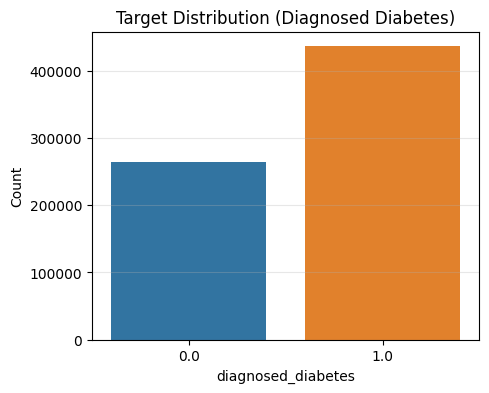

diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64


In [18]:
# visualizing the target data distribution
plt.figure(figsize=(5,4))
sns.countplot(data=train, x=train.diagnosed_diabetes)
plt.title("Target Distribution (Diagnosed Diabetes)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

print(train["diagnosed_diabetes"].value_counts(normalize=True))

<h3><b>Distribution of Few Numerical columns by Diabetes Status

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

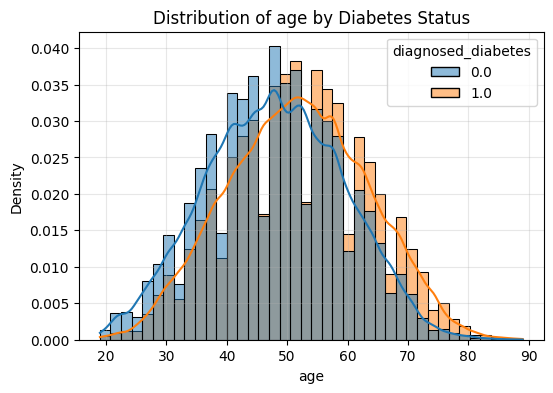

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

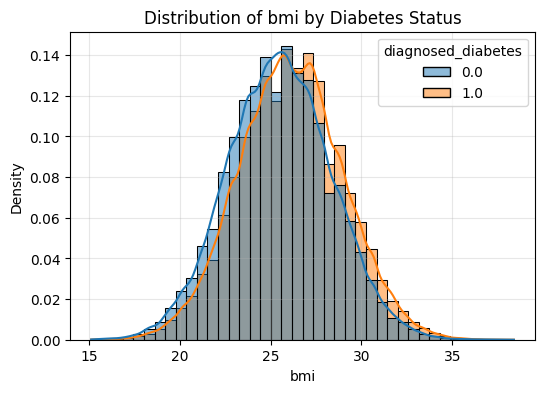

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

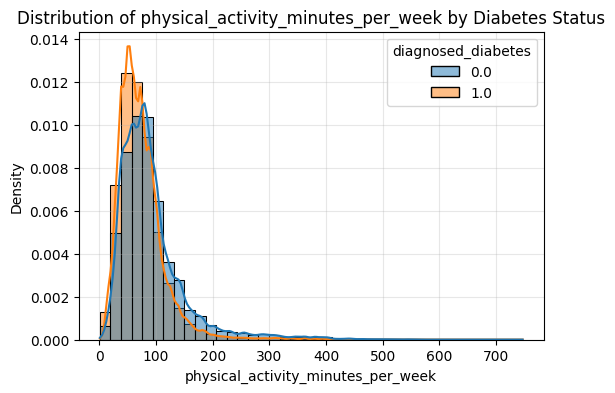

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

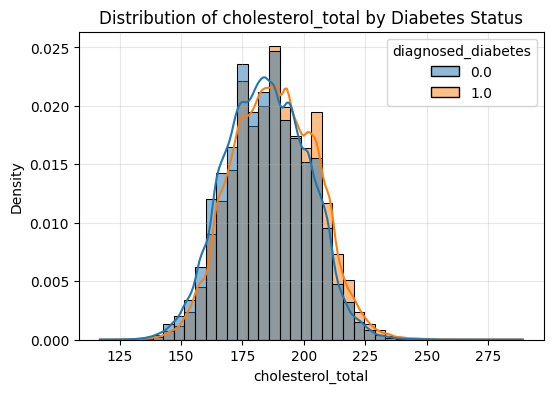

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

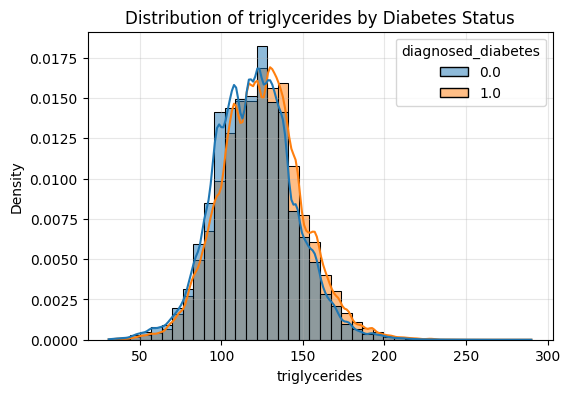

In [19]:
num_features = [
    "age",
    "bmi",
    "physical_activity_minutes_per_week",
    "cholesterol_total",
    "triglycerides"
]

for col in num_features:
    plt.figure(figsize=(6,4))
    sns.histplot(
        data=train,
        x=col,
        hue=train.diagnosed_diabetes,
        bins=40,
        kde=True,
        stat="density",
        common_norm=False
    )
    plt.title(f"Distribution of {col} by Diabetes Status")
    plt.grid(alpha=0.3)
    plt.show()

<h3><b>Numerical Column Outlier Detection using Boxplot against Diagnosed Diabetes

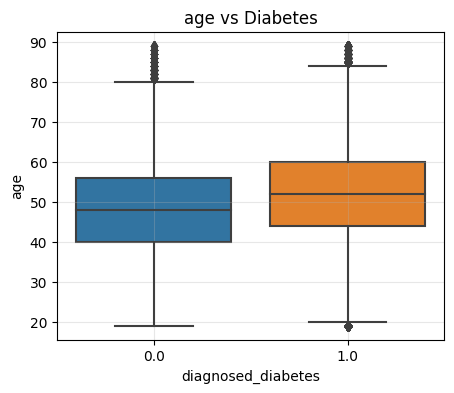

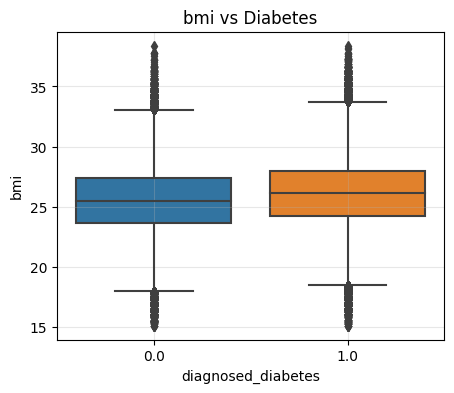

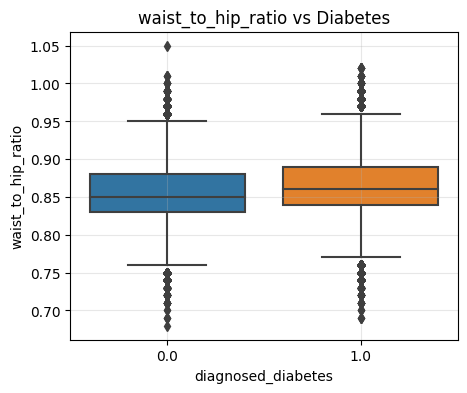

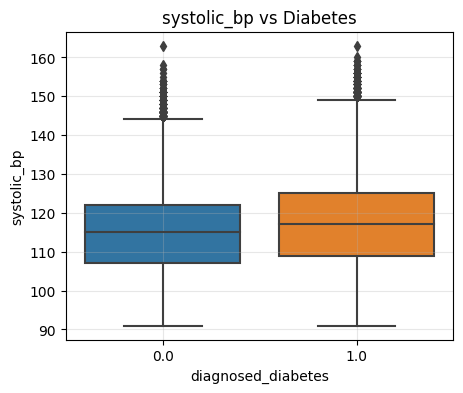

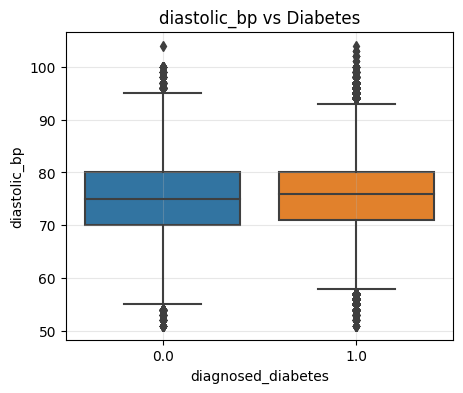

In [20]:
box_cols = [
    "age",
    "bmi",
    "waist_to_hip_ratio",
    "systolic_bp",
    "diastolic_bp"
]

for col in box_cols:
    plt.figure(figsize=(5,4))
    sns.boxplot(data=train, x=train.diagnosed_diabetes, y=col)
    plt.title(f"{col} vs Diabetes")
    plt.grid(alpha=0.3)
    plt.show()


<h3><b>BMI vs Waist-to-Hip Ratio

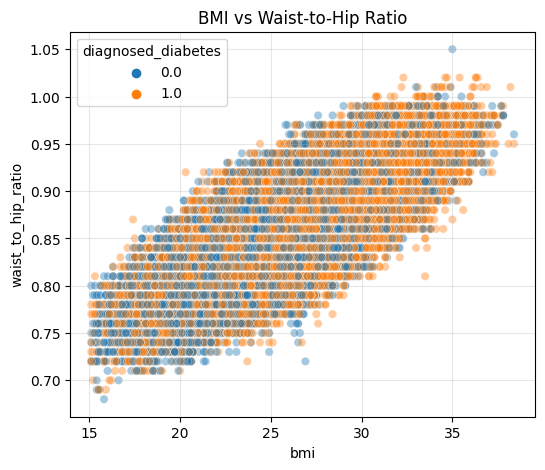

In [21]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=train,
    x="bmi",
    y="waist_to_hip_ratio",
    hue="diagnosed_diabetes",
    alpha=0.4
)
plt.title("BMI vs Waist-to-Hip Ratio")
plt.grid(alpha=0.3)
plt.show()

<h3><b>Correlation Heatmap of Key Features

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


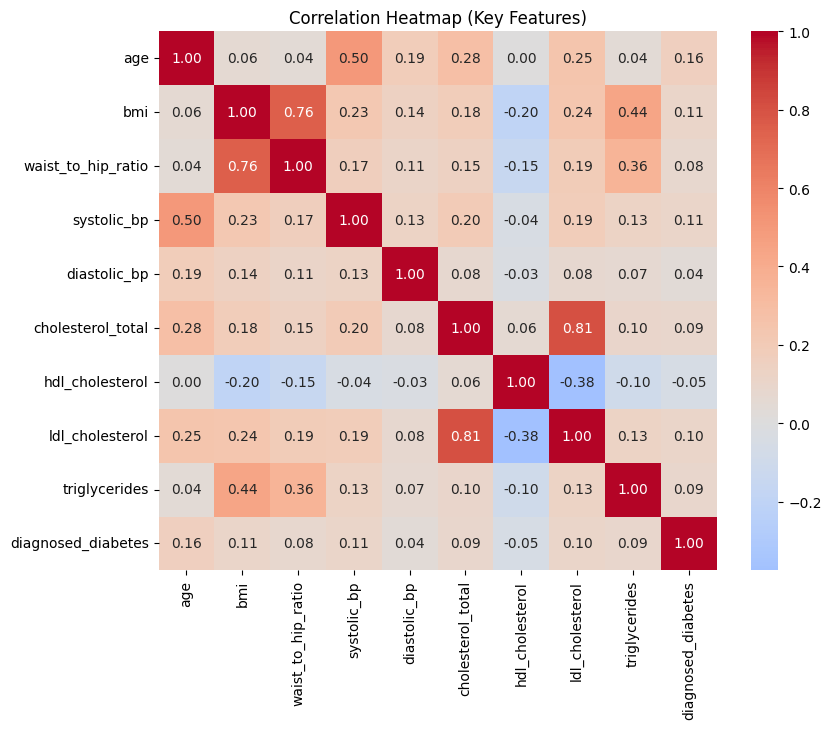

In [22]:
corr_features = [
    "age", "bmi", "waist_to_hip_ratio",
    "systolic_bp", "diastolic_bp",
    "cholesterol_total", "hdl_cholesterol",
    "ldl_cholesterol", "triglycerides",
    "diagnosed_diabetes"
]

plt.figure(figsize=(9,7))
sns.heatmap(
    train[corr_features].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap (Key Features)")
plt.show()


<h3><b>Define Training Features and Target variable (X, y)

In [23]:
TARGET = "diagnosed_diabetes" # based on the problem given, choosing diagnosed_diabetes as target variable
ID_COL = "id" # ID column would not have much value on the training and prediction quality, flagging it to exclude

# training features
features = [c for c in train.columns if c not in [TARGET, ID_COL]]

X = train[features].copy()
y = train[TARGET].copy()

X_test = test[features].copy()

<h3><b>Checking data shape of X and y splits

In [24]:
print(f"Train: {X.shape}, Test: {X_test.shape}")
print(f"Target Rate: {y.mean()}")

Train: (700000, 24), Test: (300000, 24)
Target Rate: 0.6232957142857143


<h3><b>Identify Numerical & Categorical Column

In [25]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

In [26]:
print(f"Categorical Columns: {cat_cols}")
print("---------------------------------------------------------")
print(f"Numerical Columns: {num_cols}")

Categorical Columns: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
---------------------------------------------------------
Numerical Columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


<h3><b>Domain-Aware and Safe Feature Engineering (Minimal and Row Risky)

In [27]:
# Function to create domain specific features that add value to the ROC
def add_safe_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["bp_ratio"] = df["systolic_bp"] / (df["diastolic_bp"] + 1.0)
    df["chol_ratio"] = df["ldl_cholesterol"] / (df["hdl_cholesterol"] + 1.0)
    return df

In [28]:
# Add new features to training (X) and test (X_test) features
X = add_safe_features(X)
X_test = add_safe_features(X_test)

In [29]:
# updating categorical and numerical columns after new features assignment
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

<h3><b>Convert Categorical Columns for LightGBM

In [30]:
for col in cat_cols:
    X[col] = X[col].astype("category")
    X_test[col] = X_test[col].astype("category")

<h3><b>Drift Detection (Automatic) + Drop the Unhelpful Features

In [34]:
def drift_auc_for_feature(train_col: pd.Series, test_col: pd.Series, seed=SEED) -> float:
    # Build a dataset to classify source: 0=train, 1=test
    tr = train_col.copy()
    te = test_col.copy()

    df = pd.concat([tr, te], axis=0).reset_index(drop=True)
    src = np.array([0]*len(tr) + [1]*len(te))

    # If categorical, use codes (safe drift proxy)
    if str(df.dtype) == "category" or df.dtype == "object":
        df = df.astype("category").cat.codes.replace(-1, np.nan).astype(float)
    else:
        df = pd.to_numeric(df, errors="coerce")

    # Simple impute
    vals = df.values.reshape(-1, 1)
    imp = SimpleImputer(strategy="median")
    vals = imp.fit_transform(vals)

    # Very simple LGBM classifier to detect drift on this single feature
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    oof = np.zeros(len(src))

    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.05,
        "num_leaves": 8,
        "min_data_in_leaf": 200,
        "feature_fraction": 1.0,
        "bagging_fraction": 1.0,
        "verbose": -1,
        "seed": seed,
    }

    for tr_idx, va_idx in skf.split(vals, src):
        dtr = lgb.Dataset(vals[tr_idx], label=src[tr_idx])
        dva = lgb.Dataset(vals[va_idx], label=src[va_idx])
        m = lgb.train(params, dtr, num_boost_round=300, valid_sets=[dva],
                      callbacks=[lgb.early_stopping(30, verbose=False)])
        oof[va_idx] = m.predict(vals[va_idx])

    return roc_auc_score(src, oof)

In [36]:
drift_scores = []
for col in X.columns:
    score = drift_auc_for_feature(X[col], X_test[col], seed=SEED)
    drift_scores.append((col, score))

In [37]:
drift_df = pd.DataFrame(drift_scores, columns=["feature", "drift_auc"]).sort_values("drift_auc", ascending=False)
drift_df.head(15)

,feature,drift_auc
2,physical_activity_minutes_per_week,0.581908
14,triglycerides,0.555034
11,cholesterol_total,0.531617
13,ldl_cholesterol,0.526932
25,chol_ratio,0.515214
17,education_level,0.511847
8,systolic_bp,0.511657
24,bp_ratio,0.510632
0,age,0.509597
6,bmi,0.509230


In [38]:
DROP_TOP_K = 4  # try 2, 4, 6 (start with 4)
to_drop = drift_df["feature"].head(DROP_TOP_K).tolist()

print("Dropping drifting features:", to_drop)

X = X.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

# Refresh cat columns after drop
cat_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

Dropping drifting features: ['physical_activity_minutes_per_week', 'triglycerides', 'cholesterol_total', 'ldl_cholesterol']


Visualize drift AUC distribution

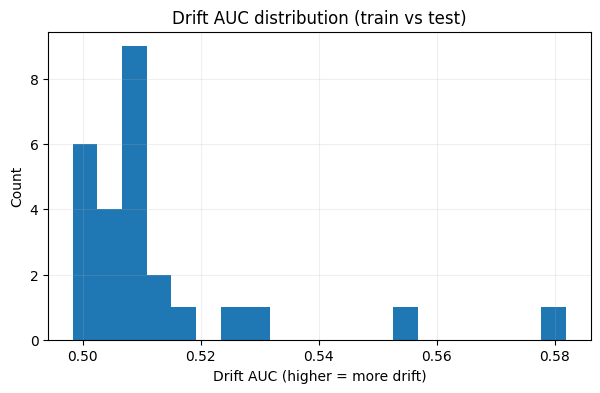

In [39]:
plt.figure(figsize=(7,4))
plt.hist(drift_df["drift_auc"], bins=20)
plt.title("Drift AUC distribution (train vs test)")
plt.xlabel("Drift AUC (higher = more drift)")
plt.ylabel("Count")
plt.grid(alpha=0.2)
plt.show()

<h3><b>Model A — Regularized LightGBM (multi-seed, repeated CV)

In [40]:
# ============================================================
# LightGBM Training Function (OOF + Test Prediction)
# ============================================================
def train_lgb_oof_test(X, y, X_test, cat_cols, seed=42):
    """
    Train a regularized LightGBM model using Repeated Stratified K-Fold CV.

    This function:
    - Generates out-of-fold (OOF) predictions for unbiased CV evaluation
    - Produces averaged test predictions across all folds
    - Uses strong regularization to improve generalization on public LB
    - Supports native categorical handling in LightGBM

    Parameters
    ----------
    X : pd.DataFrame
        Training feature matrix
    y : pd.Series
        Binary target labels
    X_test : pd.DataFrame
        Test feature matrix
    cat_cols : list
        List of categorical column names (category dtype)
    seed : int, default=42
        Random seed for reproducibility

    Returns
    -------
    oof : np.ndarray
        Out-of-fold predicted probabilities for training data
    test_pred : np.ndarray
        Averaged predicted probabilities for test data
    cv_auc : float
        ROC-AUC score computed on OOF predictions
    """

    # --------------------------------------------------------
    # Cross-validation strategy
    # --------------------------------------------------------
    # Repeated Stratified K-Fold:
    # - Maintains class balance in each fold
    # - Repetition reduces dependence on a single lucky split
    cv = RepeatedStratifiedKFold(
        n_splits=5,
        n_repeats=2,
        random_state=seed
    )

    # Initialize prediction arrays
    # OOF predictions align with training indices
    # Test predictions are accumulated and averaged across folds
    oof = np.zeros(len(X))
    test_pred = np.zeros(len(X_test))

    # --------------------------------------------------------
    # LightGBM hyperparameters (generalization-focused)
    # --------------------------------------------------------
    params = {
        "objective": "binary",          # Binary classification
        "metric": "auc",                # Evaluation metric
        "learning_rate": 0.01,          # Low LR for smoother learning
        "num_leaves": 20,               # Small tree complexity
        "max_depth": 5,                 # Limit depth to reduce overfitting
        "min_data_in_leaf": 140,        # Strong regularization
        "feature_fraction": 0.65,       # Column subsampling
        "bagging_fraction": 0.65,       # Row subsampling
        "bagging_freq": 1,
        "lambda_l1": 10,                # L1 regularization
        "lambda_l2": 25,                # L2 regularization
        "max_cat_to_onehot": 4,         # Handle small categorical features safely
        "verbose": -1,
        "seed": seed,
    }

    # --------------------------------------------------------
    # Training loop across CV folds
    # --------------------------------------------------------
    total_folds = cv.get_n_splits()

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        # Split data into training and validation sets
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        # Create LightGBM datasets
        # free_raw_data=False allows reuse of data across folds
        dtr = lgb.Dataset(
            X_tr,
            label=y_tr,
            categorical_feature=cat_cols,
            free_raw_data=False
        )
        dva = lgb.Dataset(
            X_va,
            label=y_va,
            categorical_feature=cat_cols,
            free_raw_data=False
        )

        # Train LightGBM model with early stopping
        model = lgb.train(
            params,
            dtr,
            num_boost_round=8000,            # High cap; early stopping decides
            valid_sets=[dva],
            callbacks=[lgb.early_stopping(
                stopping_rounds=300,
                verbose=False
            )]
        )

        # ----------------------------------------------------
        # Generate predictions
        # ----------------------------------------------------
        # OOF predictions for validation fold
        oof[va_idx] = model.predict(
            X_va,
            num_iteration=model.best_iteration
        )

        # Accumulate test predictions (averaged later)
        test_pred += model.predict(
            X_test,
            num_iteration=model.best_iteration
        ) / total_folds

    # --------------------------------------------------------
    # Final CV evaluation using OOF predictions
    # --------------------------------------------------------
    cv_auc = roc_auc_score(y, oof)

    return oof, test_pred, cv_auc

In [41]:
SEEDS = [42, 1337, 2025]  # seed averaging helps LB stability

In [42]:
oof_lgb_all = []
test_lgb_all = []
auc_lgb_all = []

for s in SEEDS:
    oof_s, test_s, auc_s = train_lgb_oof_test(X, y, X_test, cat_cols, seed=s)
    oof_lgb_all.append(oof_s)
    test_lgb_all.append(test_s)
    auc_lgb_all.append(auc_s)
    print(f"LGB seed {s} CV AUC: {auc_s:.5f}")

LGB seed 42 CV AUC: 0.67074
LGB seed 1337 CV AUC: 0.67078
LGB seed 2025 CV AUC: 0.67079


In [43]:
# ============================================================
# LightGBM: Seed-Averaged Predictions (Variance Reduction)
# ============================================================
# Motivation:
# - Individual random seeds can produce slightly different models
# - Averaging across multiple seeds improves robustness
# - Reduces sensitivity to lucky/unlucky initializations
# - Typically narrows the CV–Public LB gap in Playground datasets

# Average out-of-fold predictions across all trained seeds
oof_lgb = np.mean(oof_lgb_all, axis=0)

# Average test predictions across all trained seeds
test_lgb = np.mean(test_lgb_all, axis=0)

# Evaluate LightGBM using seed-averaged out-of-fold predictions
print("LightGBM Seed-Averaged CV AUC:",
      roc_auc_score(y, oof_lgb))

LightGBM Seed-Averaged CV AUC: 0.6709433351717473


<h3><b>Model B — Logistic Regression baseline (stable) + blend

In [44]:
# ============================================================
# Logistic Regression: Preprocessing Pipeline Construction
# ============================================================
# Goal:
# - Prepare numerical and categorical features appropriately
# - Ensure Logistic Regression receives scaled, well-imputed inputs
# - Build a reusable and leakage-safe preprocessing pipeline

# ----------------------------
# Numerical feature pipeline
# ----------------------------
# Steps:
# 1. Impute missing values using median (robust to outliers)
# 2. Standardize features (required for linear models)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# ----------------------------
# Categorical feature pipeline
# ----------------------------
# Steps:
# 1. Impute missing values using most frequent category
# 2. One-hot encode categories
#    - handle_unknown='ignore' prevents inference-time errors
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", __import__("sklearn").preprocessing.OneHotEncoder(
        handle_unknown="ignore"
    )),
])

# ----------------------------
# Column-wise preprocessing
# ----------------------------
# Applies:
# - Numerical pipeline to numerical columns
# - Categorical pipeline to categorical columns
# Drops any columns not explicitly listed (safety measure)
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# ----------------------------
# Final Logistic Regression pipeline
# ----------------------------
# Combines preprocessing + model into a single object
# class_weight='balanced' compensates for target imbalance
lr_model = Pipeline(steps=[
    ("prep", preprocess),
    ("lr", LogisticRegression(
        max_iter=4000,
        class_weight="balanced"
    )),
])

In [45]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
oof_lr = np.zeros(len(X))
test_lr = np.zeros(len(X_test))

In [46]:
# ============================================================
# Logistic Regression: Stratified K-Fold Training & Evaluation
# ============================================================
# Purpose:
# - Acts as a stable baseline model
# - Provides robust predictions under distribution shift
# - Serves as a regularizing component in the final ensemble

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    # Train Logistic Regression on the current training fold
    lr_model.fit(X.iloc[tr_idx], y.iloc[tr_idx])

    # Generate out-of-fold predictions for validation data
    # These predictions are used for unbiased CV AUC estimation
    oof_lr[va_idx] = lr_model.predict_proba(X.iloc[va_idx])[:, 1]

    # Generate predictions for the test set
    # Average predictions across folds to reduce variance
    test_lr += lr_model.predict_proba(X_test)[:, 1] / skf.n_splits

# Evaluate Logistic Regression using full out-of-fold predictions
print("Logistic Regression CV AUC:", roc_auc_score(y, oof_lr))

Logistic Regression CV AUC: 0.6675552440968471


In [47]:
# ============================================================
# Final Conservative Ensemble (LightGBM + Logistic Regression)
# ============================================================
# Motivation:
# - LightGBM captures nonlinear patterns and interactions
# - Logistic Regression provides stability under distribution shift
# - A conservative weighted blend improves generalization on Public LB

# Blend out-of-fold predictions (used for unbiased CV evaluation)
oof_blend = (
    0.85 * oof_lgb   # Primary model: regularized LightGBM (strong signal)
    + 0.15 * oof_lr  # Stabilizer: Logistic Regression (robust baseline)
)

# Blend test predictions using the same weights
test_blend = (
    0.85 * test_lgb  # Majority contribution from LightGBM
    + 0.15 * test_lr # Smaller contribution to reduce overfitting risk
)

# Evaluate blended model using out-of-fold predictions
print("Blended CV AUC (LightGBM + Logistic Regression):",
      roc_auc_score(y, oof_blend))

Blended CV AUC (LightGBM + Logistic Regression): 0.6708571588044714


<h3><b>Sanity checks + ROC plot (OOF)

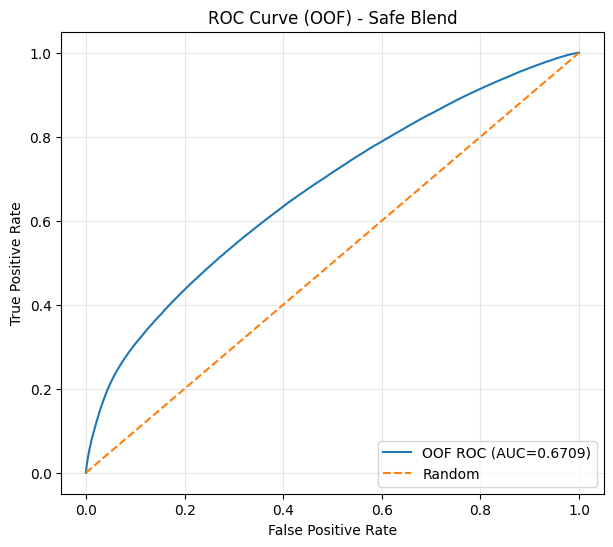

In [48]:
fpr, tpr, _ = roc_curve(y, oof_blend)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"OOF ROC (AUC={roc_auc:.4f})")
plt.plot([0,1], [0,1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF) - Safe Blend")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [49]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e12/sample_submission.csv")
sub[TARGET] = test_blend

out_path = "/kaggle/working/submission_lgb_no_catboost.csv"
sub.to_csv(out_path, index=False)

print("Saved:", out_path)
sub.head()

Saved: /kaggle/working/submission_lgb_no_catboost.csv


,id,diagnosed_diabetes
0,700000,0.540075
1,700001,0.512433
2,700002,0.576960
3,700003,0.573921
4,700004,0.732144
